# Consultas


### 1) What are the most and least demanded jobs?



```
SELECT job_desc,
       Count(*) AS number_of_employees
FROM   employee
       INNER JOIN jobs
               ON employee.job_id = jobs.job_id
GROUP  BY job_desc
ORDER  BY number_of_employees DESC

```

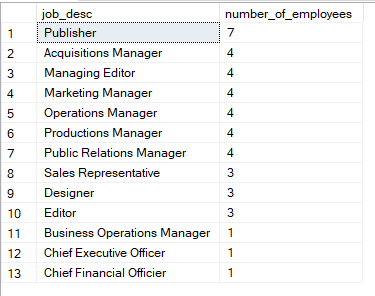

What have i learned from this query:
-  SQL Server does not support USING in JOINS

### 2) Average level of employees for each employee compared to the maximum and minimum level?







```
SELECT
    j.job_desc,
    AVG(e.job_lvl) AS average_lvl,
    MAX(j.min_lvl) AS min_lvl,
    MAX(j.max_lvl) AS max_lvl,  
	CAST(ABS(AVG(e.job_lvl) - MAX(j.min_lvl)) / ((AVG(e.job_lvl) + MAX(j.min_lvl)) / 2.0) * 100 AS DECIMAL(4, 2)) AS diff_minl, --Dividimos por 2.0 para que el resultado sea float, DECIMAL(4, 2) porque es un porcentaje y no va a tener más de 3 dígitos
	CAST(ABS(AVG(e.job_lvl) - MAX(j.max_lvl)) / ((AVG(e.job_lvl) + MAX(j.max_lvl)) / 2.0) * 100 AS DECIMAL(4, 2)) AS diff_maxl
FROM
    employee e
    INNER JOIN jobs j ON e.job_id = j.job_id
GROUP BY
    j.job_desc;

```

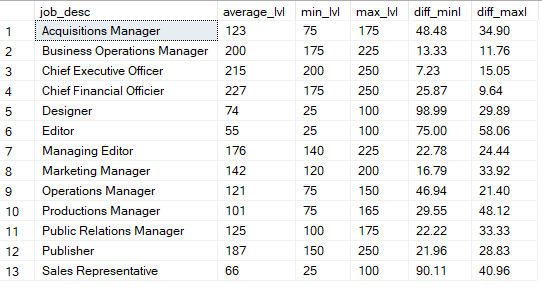

Things I learned from this query:
- If you divide two integers in SQL Server, the result is an integer, and decimals are truncated.
- Use the CAST or CONVERT function to perform the conversion.
- Formula for calculating the percentage difference between two numbers. \
- [The ABS function does not convert to an integer if passed a float.](https://learn.microsoft.com/es-es/sql/t-sql/functions/abs-transact-sql?view=sql-server-ver16)
- Precision of different numeric types, [decimal](https://learn.microsoft.com/es-es/sql/t-sql/data-types/decimal-and-numeric-transact-sql?view=sql-server-ver16) allows you to specify how many digits you want before and after the decimal point.

### 3) What dates are more/less people hired?


I decided to group the result by country since each country has different regulations regarding hiring staff and this could affect the dates.

```
SELECT MONTH(e.hire_date) AS month_hd,
	   p.country,
	   COUNT(*)
FROM employee AS e INNER JOIN publishers AS p ON e.pub_id = p.pub_id
GROUP BY MONTH(e.hire_date), p.country
```

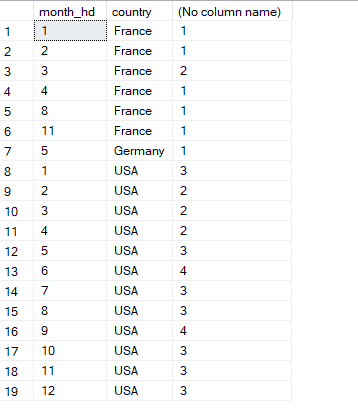

I was curious about the german publisher that only has one employee, so i look it up:
```
SELECT *
FROM employee AS e INNER JOIN publishers AS p ON e.pub_id = p.pub_id
INNER JOIN jobs AS j ON (e.job_id = j.job_id)
WHERE p.country = 'Germany'
```
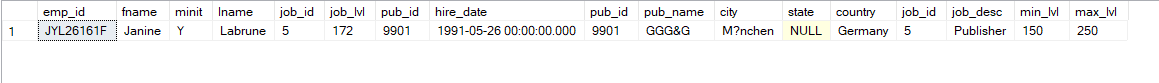

Things i learned from this query:
- To obtain the month in a DATE we use the MONTH funcion, [date management in SQL SERVER](https://learn.microsoft.com/en-us/sql/t-sql/functions/date-and-time-data-types-and-functions-transact-sql?view=sql-server-ver16)
- You can not group by a column created in the SELECT because the SELECT is executed after the GROUP BY (this will result in an error):
```
SELECT MONTH(hire_date) as month_hd
FROM employee
GROUP BY month_hd
```
This also applies to any part of the query executed before the SELECT: FROM, WHERE, GROUP BY, HAVING

### 4) Number of employees per publisher?


```
SELECT MAX(p.pub_name) AS pub_name,
       COUNT(*) AS number_of_employees
FROM employee e INNER JOIN publishers p ON (e.pub_id = p.pub_id)
GROUP BY p.pub_id
ORDER BY number_of_employees DESC
```

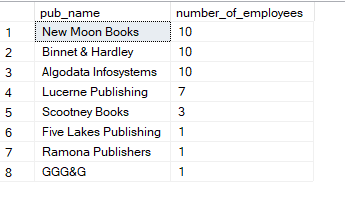


This i learned from this query:
- In the FROM clause, it is not necessary to use "AS" to assign aliases; simply writing the table name, a space, and the alias is enough:

```
SELECT p.pub_id FROM publishers p
```

### 5) best-selling books/book types?

```
SELECT t.type, SUM(qty) AS total_sales
FROM titles t
INNER JOIN sales s ON t.title_id = s.title_id
GROUP BY t.type
ORDER BY total_sales DESC

SELECT s.title_id, SUM(qty) AS total_sales
FROM titles t
INNER JOIN sales s ON t.title_id = s.title_id
GROUP BY s.title_id
ORDER BY total_sales DESC
```
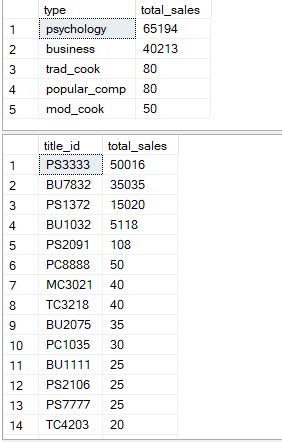

### 6) How many books has each author written?

```
-- number of books per author (including secondary author)

SELECT MAX(a.au_fname) AS fname,
       MAX(a.au_lname) AS lname,
	   COUNT(*) AS number_of_books
FROM authors a
INNER JOIN titleauthor t ON a.au_id=t.au_id
GROUP BY a.au_id
ORDER BY number_of_books DESC

-- number of books per author (only first author)

SELECT MAX(a.au_fname) AS fname,
       MAX(a.au_lname) AS lname,
	   COUNT(*) AS number_of_books
FROM authors a
INNER JOIN titleauthor t ON a.au_id=t.au_id
WHERE au_ord=1
GROUP BY a.au_id
ORDER BY number_of_books DESC

-- number of books per author per category

SELECT MAX(a.au_fname) AS fname,
       MAX(a.au_lname) AS lname,
	   ti.type,
	   COUNT(*) AS number_of_books
FROM authors a
INNER JOIN titleauthor t ON a.au_id=t.au_id
INNER JOIN titles ti ON ti.title_id = t.title_id
GROUP BY a.au_id, ti.type
ORDER BY number_of_books DESC, fname
```

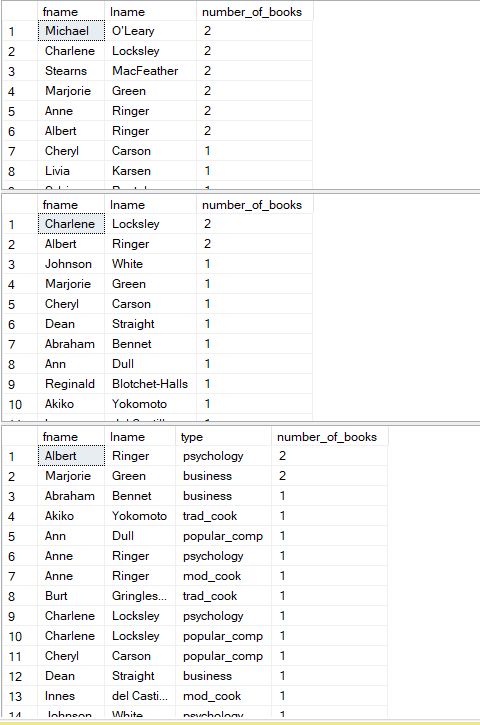

### 7) How much money has each author made?


To calculate how much money each author has made we have to take into account the royalties and the discounts, however this can be a little confusing.\
Starting with the royalties we can see that three different tables assing them:
- "roysched" assigns royalties based on the number of copies sold
- "titles" assigns a royalty to each book, this number is used in case "roysched" does not contain any record with that book or the number of copies sold does not fall within any range in "roysched" for that book
- "titleauthor" assigns the percentage of the sale that goes to each author (many books have multiple authors, so they must split the earnings)

When it comes to the discounts there is one that we can not apply, if we look at the discount table:

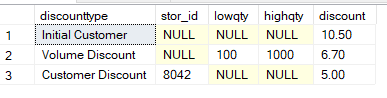

We can see that there is an "Initial customer" discount applied to all stores. However, the "sales" table does not store any information about the clients, so we cannot determine when to apply this discount. Unless we apply it every time there is a sale we cannot be certain, as this discount has no lowqty or highqty thresholds and applies to every store. For this reason i will not be applying this discount.\
A similar case happens with the "Customer discount", a discount that can only be applied in one store but applies every time if we do it automatically.

This makes me think that the real way of applying the discounts is manually, since we have a discounts that, if applied automatically, they would apply to every sale.

So, when we want to know the money an author made we have to:
1. Calculate the total amount made in the sale by multiplying the number of copies sold and the price of the book
2. Apply discounts if we want to apply them
3. Subtract the royalties of the total amount using "roysched" or the royalty in "titles"
4. Distribute the remaining amount among the authors using 'titleauthor using "titleauthor"  

In the process of getting the right query, i did this one and realized that every sale has the same royalty:
```
SELECT s.ord_num, t.title_id, s.qty, t.price, t.price*s.qty AS total_price,
(SELECT r.royalty FROM roysched r WHERE r.title_id=t.title_id AND s.qty BETWEEN r.lorange AND r.hirange) AS royalty_roysched
FROM titles t INNER JOIN sales s ON t.title_id=s.title_id
```
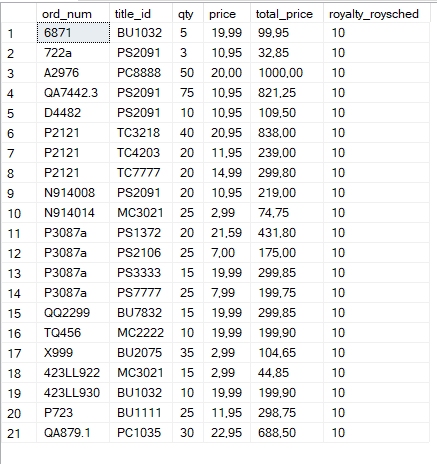

So I will add some new data to the sales table in order to have sales with different royalties, and sales that use the royalty in the "titles" table. This is the new data I introduced:

```
insert sales values('7066','P29300', CONVERT(DATETIME, '2024-12-26', 120), 5002, 'Net 30', 'BU1032')
insert sales values('7066','P29301', CONVERT(DATETIME, '2024-12-26', 120), 35020, 'Net 30', 'BU7832')
insert sales values('7067','P29302', CONVERT(DATETIME, '2024-12-26', 120), 15000, 'Net 60', 'PS1372')
insert sales values('8042','P29303', CONVERT(DATETIME, '2024-12-26', 120), 50001, 'Net 60', 'PS3333')
insert sales values('8042','P29304', CONVERT(DATETIME, '2024-12-26', 120), 101, 'Net 60', 'BU1032')
```

In order to introduce this new data i had to change the type of the qty column in sales from SMALLINT to INT:
```
ALTER TABLE sales
ALTER COLUMN qty INT;
```
Now that we have this new data we can be sure that the query is working as expected:
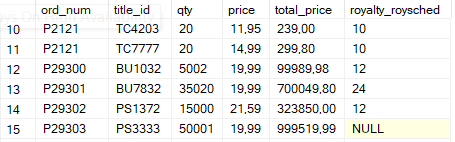

I also updated the 'Volume discount' in the "discount" table so that some of the sales I introduced have the discount applied to them

```
UPDATE discounts
SET highqty = 20000
WHERE discounttype = 'Volume discount';
```

To be able to know the total discount a sale has I made this view:
```
CREATE VIEW v_discount_per_sale AS
SELECT
    ord_num,
    title_id,
    CASE
        WHEN total_discount > 100 THEN 100
        ELSE total_discount
    END AS total_discount
FROM (
    SELECT
        ord_num,
        title_id,
        SUM(discount) AS total_discount
    FROM
        discounts d
    RIGHT JOIN
        sales s ON ((s.stor_id = d.stor_id OR d.stor_id IS NULL))
        AND ((d.lowqty IS NULL OR s.qty >= d.lowqty)
        AND (d.highqty IS NULL OR s.qty <= d.highqty))
        AND d.discounttype != 'Initial Customer'
    GROUP BY
        ord_num, title_id
) AS sub_query;
```
I used a sub_query so I didn't have to calculate SUM(discount) two times in the CASE statement



```
-- Without applying discounts
SELECT
    ath.au_fname,
	ath.au_lname,
	SUM(((t.price * s.qty)*(COALESCE(r.royalty, t.royalty)/100.0)) * (ta.royaltyper/100.0)) AS earned
FROM
    titles t
INNER JOIN
    sales s ON t.title_id = s.title_id
LEFT JOIN
    roysched r ON r.title_id = t.title_id AND s.qty BETWEEN r.lorange AND r.hirange
INNER JOIN
	titleauthor ta ON t.title_id = ta.title_id
INNER JOIN
	authors ath ON ath.au_id = ta.au_id
GROUP BY
	au_fname, au_lname
ORDER BY earned DESC

-- Applying discounts
SELECT
    ath.au_fname,
    ath.au_lname,
    SUM(((tl.price * s.qty) * (1.0 - (COALESCE(vd.total_discount, 0)/100.0))*(COALESCE(r.royalty, tl.royalty)/100.0)) * (ta.royaltyper/100.0)) AS earned
FROM
    sales s
INNER JOIN
	v_discount_per_sale AS vd ON s.title_id = vd.title_id AND s.ord_num = vd.ord_num
INNER JOIN
    titles tl ON s.title_id = tl.title_id
LEFT JOIN
    roysched r ON r.title_id = tl.title_id AND s.qty BETWEEN r.lorange AND r.hirange
INNER JOIN
    titleauthor ta ON tl.title_id = ta.title_id
INNER JOIN
    authors ath ON ath.au_id = ta.au_id
GROUP BY
    au_fname, au_lname
ORDER BY earned DESC
```
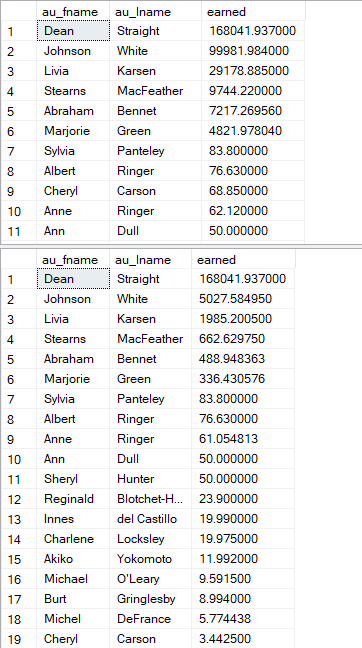

What have i learned from this query:
- If your query uses a CASE statement and the condition is "IS NULL" you probably should use a COALESCE instead, my first aproach to the query:
```
SELECT s.ord_num, t.title_id, s.qty, t.price, t.price * s.qty AS total_price,
CASE
  WHEN (SELECT r.royalty
        FROM roysched r
        WHERE r.title_id = t.title_id
          AND s.qty BETWEEN r.lorange AND r.hirange) IS NULL
    THEN t.royalty
  ELSE (SELECT r.royalty
        FROM roysched r
        WHERE r.title_id = t.title_id
          AND s.qty BETWEEN r.lorange AND r.hirange)
END AS royalty
FROM titles t
INNER JOIN sales s ON t.title_id = s.title_id
ORDER BY ord_num;
```
- Review the types of JOIN in SQL

### 8) Which stores have sold more than 3 different titles and what is the total number of books sold by each one?







```
SELECT s.stor_id, SUM(qty) AS total_sales
FROM sales s
INNER JOIN titles t ON s.title_id = t.title_id
WHERE s.stor_id IN (SELECT s.stor_id
					FROM sales s
					GROUP BY s.stor_id
					HAVING COUNT(DISTINCT s.title_id) > 3)
GROUP BY s.stor_id
ORDER BY total_sales DESC
```

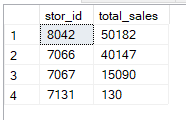

### 9) What books have an average royalty greater than 15% and how many of those books have been sold



```
SELECT s.title_id, SUM(s.qty)
FROM sales s
WHERE s.title_id IN (SELECT
    title_id
FROM (
    SELECT title_id, royalty FROM roysched
    UNION ALL
    SELECT title_id, royalty FROM titles
) AS combined
GROUP BY title_id
HAVING AVG(royalty) > 15)
GROUP BY s.title_id
```

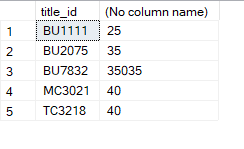

Things i learned from this query:

[UNION](https://learn.microsoft.com/en-us/sql/t-sql/language-elements/set-operators-union-transact-sql?view=sql-server-ver16)

### 10) Which store made the most money, and which are the 5 bestsellers for that store?

```
-- Without applying discounts
SELECT TOP 5 stor_id, title_id, SUM(qty) AS number_copies_sold
FROM sales
WHERE stor_id = (SELECT TOP 1 s.stor_id
	FROM sales s
	INNER JOIN titles t ON s.title_id = t.title_id
	LEFT JOIN roysched r ON r.title_id=t.title_id AND r.title_id = t.title_id AND s.qty BETWEEN r.lorange AND r.hirange
	GROUP BY s.stor_id
	ORDER BY SUM((s.qty * t.price) * (1-(COALESCE(r.royalty, t.royalty)/100.0)))  DESC)
GROUP BY stor_id, title_id
ORDER BY number_copies_sold DESC

-- Applying discounts
SELECT TOP 5 stor_id, title_id, SUM(qty) AS number_copies_sold
FROM sales
WHERE stor_id = (SELECT TOP 1 s.stor_id
	FROM sales s
	INNER JOIN
    v_discount_per_sale AS vd ON s.title_id = vd.title_id AND s.ord_num = vd.ord_num
	INNER JOIN titles t ON s.title_id = t.title_id
	LEFT JOIN roysched r ON r.title_id=t.title_id AND r.title_id = t.title_id AND s.qty BETWEEN r.lorange AND r.hirange
	GROUP BY s.stor_id
	ORDER BY SUM((s.qty * t.price)*(1.0-(COALESCE(vd.total_discount, 0)/100.0))*(1-(COALESCE(r.royalty, t.royalty)/100.0))) DESC)
GROUP BY stor_id, title_id
ORDER BY number_copies_sold DESC

```
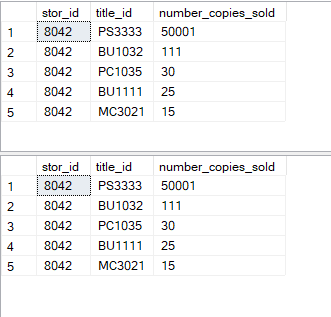


Things i learned from this query:
[TOP](https://learn.microsoft.com/en-us/sql/t-sql/queries/top-transact-sql?view=sql-server-ver16)

### 11) Which authors have a best-selling book that has generated more income than the average income of all books?



Let's take the income of a book as the total money made in the sale (price * number of books sold)
```
SELECT au_id, t.title_id
FROM sales s
INNER JOIN
titles t ON s.title_id = t.title_id
INNER JOIN
titleauthor ta ON t.title_id = ta.title_id
GROUP BY ta.au_id, t.title_id
HAVING SUM(qty) >= ALL(SELECT SUM(qty)
					   FROM sales s2
                       INNER JOIN
                       titles t2 ON s2.title_id = t2.title_id
                       INNER JOIN
                       titleauthor ta2 ON t2.title_id = ta2.title_id
                       WHERE ta2.au_id=ta.au_id
                       GROUP BY ta2.au_id, t2.title_id)
		AND
		AVG(t.price * s.qty) > (SELECT AVG(t.price * s.qty) FROM sales s INNER JOIN titles t ON s.title_id = t.title_id)
```

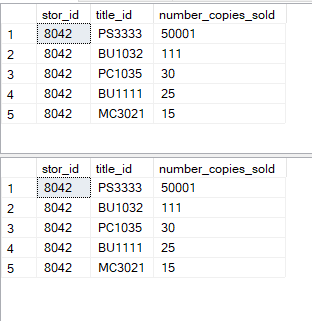

Things I learned from this query:
[ALL](https://learn.microsoft.com/es-es/sql/t-sql/language-elements/all-transact-sql?view=sql-server-ver16)

### 12) Wich publishers have sold books with a discount greater than 5% and what is the average discount per publisher?

```
SELECT DISTINCT p.pub_id
FROM v_discount_per_sale d
INNER JOIN titles t ON d.title_id = t.title_id
INNER JOIN publishers p ON p.pub_id = t.pub_id
WHERE d.total_discount > 5.0

SELECT p.pub_id, AVG(d.total_discount)
FROM v_discount_per_sale d
INNER JOIN titles t ON d.title_id = t.title_id
INNER JOIN publishers p ON p.pub_id = t.pub_id
GROUP BY p.pub_id

```

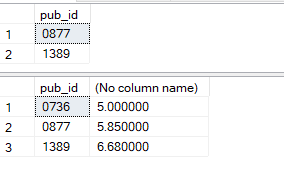

### 13) Which author has contributed the most to the total sales of their publisher, considering the sales of all their books?



```
SELECT TOP 1
ta.au_id, t.pub_id, SUM(qty) AS copies_per_author_per_pub, MAX(copies_sold_by_pub) AS total_sales_pub, MAX(copies_sold_by_pub) - SUM(qty) AS difference_
FROM sales s
INNER JOIN titles t ON s.title_id = t.title_id
INNER JOIN (SELECT t.pub_id, SUM(qty) AS copies_sold_by_pub
	FROM sales s
	INNER JOIN titles t ON t.title_id = s.title_id
	GROUP BY t.pub_id) AS copies_sold_by_pub ON copies_sold_by_pub.pub_id = t.pub_id
INNER JOIN titleauthor ta ON ta.title_id= t.title_id
GROUP BY ta.au_id, t.pub_id
ORDER BY MAX(copies_sold_by_pub) - SUM(qty) ASC
```

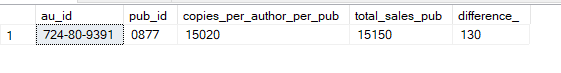

### 14) Which are the top 5 bestselling books that have tiered royalties defined in the roysched table, and what is the total amount paid in royalties for each one?

Taking sales as number of copies sold
```
SELECT TOP 5 t.title_id, SUM((qty*price) * (COALESCE(r.royalty, t.royalty)/100.0)) AS royalties_paid FROM sales s
INNER JOIN titles t ON s.title_id = t.title_id
LEFT JOIN roysched r ON r.title_id = t.title_id AND s.qty BETWEEN r.lorange AND r.hirange
WHERE t.title_id IN (SELECT DISTINCT r2.title_id FROM roysched r2) -- We make sure that the title is in roysched
GROUP BY t.title_id
ORDER BY SUM(qty) DESC
```

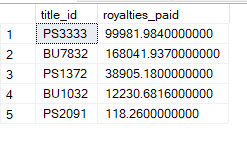

### 15) Which author has the most expensive book published, and what is the total sales volume of that book?



```
-- First author only
SELECT t.title_id, SUM(qty)
FROM titles t
INNER JOIN sales s ON t.title_id = s.title_id
INNER JOIN titleauthor ta ON t.title_id = ta.title_id AND ta.au_ord = 1
WHERE t.title_id = (SELECT TOP 1 t.title_id FROM titles t ORDER BY price DESC)
GROUP BY t.title_id


-- Including all authors
SELECT t.title_id, ta.au_id, SUM(qty)
FROM titles t
INNER JOIN sales s ON t.title_id = s.title_id
INNER JOIN titleauthor ta ON t.title_id = ta.title_id
WHERE t.title_id = (SELECT TOP 1 t.title_id FROM titles t ORDER BY price DESC)
GROUP BY t.title_id, ta.au_id
```

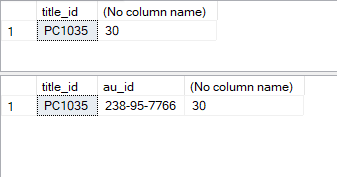

### 16) Which books have no sales recorded in the sales table, and which publisher do they belong to?

```
SELECT t.title_id, pub_id
FROM titles t
LEFT JOIN sales s ON t.title_id = s.title_id
WHERE s.title_id IS NULL
```
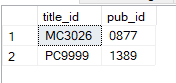

### 17) Which are the most commonly applied discounts in sales, and which titles are being sold in those sales?

```
SELECT discounttype,title_id, COUNT(*) AS times_applied
FROM      dbo.discounts AS d INNER JOIN
          dbo.sales AS s ON (s.stor_id = d.stor_id OR
          d.stor_id IS NULL) AND (d.lowqty IS NULL OR
          s.qty >= d.lowqty) AND (d.highqty IS NULL OR
          s.qty <= d.highqty) AND d.discounttype <> 'Initial Customer'
GROUP BY discounttype, title_id
ORDER BY discounttype
```

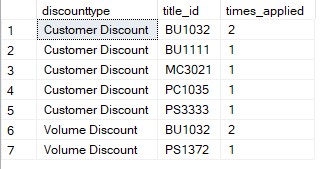

### 18) Which store has sold the most copies of a single title, and what is that title?



```
SELECT stor_id, title_id
FROM sales
GROUP BY stor_id, title_id
HAVING SUM(qty) >= ALL(SELECT SUM(s2.qty) FROM sales s2 GROUP BY s2.stor_id, s2.title_id)
```

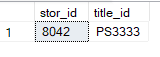

### 19) How many employees work in publishers that have at least 2 books published with sales greater than 1000 copies?

```
SELECT pub_id, COUNT(*)
FROM employee
WHERE pub_id = ANY(SELECT pub_id
FROM (SELECT pub_id, t.title_id, SUM(qty) AS sales
		FROM sales s
		INNER JOIN titles t ON s.title_id = t.title_id
		GROUP BY pub_id, t.title_id
		HAVING SUM(qty) > 1000) AS sub_query
GROUP BY pub_id
HAVING COUNT(*) >= 2)
GROUP BY pub_id
```
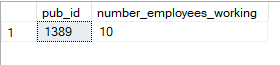

### 20) Which authors haven't received any payments in royalties based on the sales of their books?



```
SELECT DISTINCT a.au_id, a.au_fname, a.au_lname
FROM sales s
INNER JOIN titles t ON s.title_id = t.title_id
INNER JOIN titleauthor ta ON ta.title_id = t.title_id
RIGHT JOIN authors a ON ta.au_id = a.au_id
WHERE ta.au_id IS NULL
```

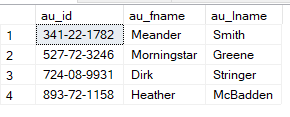

### 21) Which books have more than one author, and what is the total number of copies sold for each of those books?

```
SELECT t.title_id, SUM(qty)
FROM sales s
INNER JOIN titles t ON t.title_id = s.title_id
WHERE t.title_id IN (SELECT title_id
						FROM titleauthor
						GROUP BY title_id
						HAVING COUNT(*) >= 2)
GROUP BY t.title_id
```

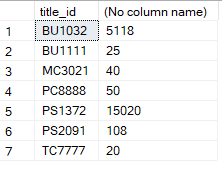

### 22) What is the average income generated by the sales of each publisher, and what percentage of the total does it represent?"

```
SELECT t.pub_id, AVG(qty*price) AS average_income, (AVG(s.qty*t.price)/(SELECT SUM(qty*price)
									FROM sales s2
									INNER JOIN titles t2 ON s2.title_id = t2.title_id
									WHERE t.pub_id = t2.pub_id)) * 100.0 AS percentage_relative_to_the_total
FROM sales s
INNER JOIN titles t ON s.title_id = t.title_id
GROUP BY t.pub_id
```

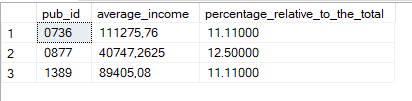

### 23) Which authors have books sold in stores that apply more than two different discounts?

```
SELECT DISTINCT ta.au_id
FROM sales s
INNER JOIN titles t ON t.title_id = s.title_id
INNER JOIN titleauthor ta ON ta.title_id = t.title_id
WHERE s.stor_id IN (SELECT s.stor_id
					FROM discounts d
					INNER JOIN stores s ON (s.stor_id = d.stor_id OR d.stor_id IS NULL)
					GROUP BY s.stor_id
					HAVING COUNT(*) >= 3)
```
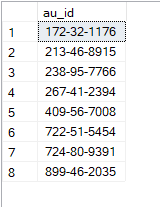

Things i learned with this query:
- When you group by a column that has NULL values in it, it treats the NULL's as another value of the column